In [15]:
# ライブラリ読み込み
import numpy as np
import pandas as pd

from load_data import load2d
from saver import load_arch
from plotter import plot_samples

In [3]:
# 定数
SPECIALIST_SETTINGS = [
    dict(
        id='1',
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        id='2',
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        id='3',
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        id='4',
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        id='5',
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        id='6',
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [4]:
# テストデータ読み込み
X_test2d, _ = load2d(test=True)

ImageId    1783
Image      1783
dtype: int64


In [7]:
# モデル読み込み
models = []
model_name = 'model8'
outpath = 'results/' + model_name + '-5000.csv'

for i, setting in enumerate(SPECIALIST_SETTINGS):
    
    # arch file: model/model8-{1-6}-arch-5000.json
    # weights file: model/model8-{1-6}-weights-5000.json
    model_arch = 'model/' + model_name + '-' + setting['id'] + '-arch-5000.json'
    model_weights = 'model/' + model_name + '-' + setting['id'] + '-weights-5000.hdf5'

    # モデルの読み込み
    models.append(load_arch(model_arch))
    models[i].load_weights(model_weights)

In [31]:
# 予測
preds = []

for i, model in enumerate(models):
    preds.append(model.predict(X_test2d))
    print('model' + str(i) + ': ', preds[i].shape)

model0:  (1783, 4)
model1:  (1783, 2)
model2:  (1783, 6)
model3:  (1783, 2)
model4:  (1783, 8)
model5:  (1783, 8)


In [76]:
a = np.c_[preds[0][:, 0], preds[0][:, 1], preds[0][:, 2], preds[0][:, 3]]
b = preds[0]
a.shape, b.shape

((1783, 4), (1783, 4))

In [78]:
# 予測を結合 (1783, 30)
y_test = np.c_[    
    preds[0],
    preds[4][:, 0], preds[4][:, 1], preds[4][:, 4], preds[4][:, 5], preds[4][:, 2], preds[4][:, 3], preds[4][:, 6], preds[4][:, 7],
    preds[5][:, 0], preds[5][:, 1], preds[5][:, 4], preds[5][:, 5], preds[5][:, 2], preds[5][:, 3], preds[5][:, 6], preds[5][:, 7],
    preds[1][:, 0], preds[1][:, 1],
    preds[2][:, 0], preds[2][:, 1], preds[2][:, 2], preds[2][:, 3], preds[2][:, 4], preds[2][:, 5],
    preds[3][:, 0], preds[3][:, 1]
]
y_test.shape

(1783, 30)

In [79]:
# 予測から結果へのデータをフィットさせる
# データのスケールを元に戻す、かつ、0〜96の値に正規化する
outputs = []
base_df = pd.read_csv('./data/IdLookupTable.csv')
for imageId in range(1, 1783+1):
    y_pred = y_test[imageId-1] # 1から始まるので0からにするため-1に。
    specified_image_id_df = base_df[base_df['ImageId'] == imageId]
    for _, row in specified_image_id_df.iterrows():
        row_id = row['RowId']
        feature_name = row['FeatureName']
        mapped_index = mappings[feature_name]
        pred_value = y_pred[mapped_index] * 48 + 48
        if pred_value > 96.0:
            pred_value = 96.0
        if pred_value < 0.0:
            pred_value = 0.0
        outputs.append([row_id, pred_value])

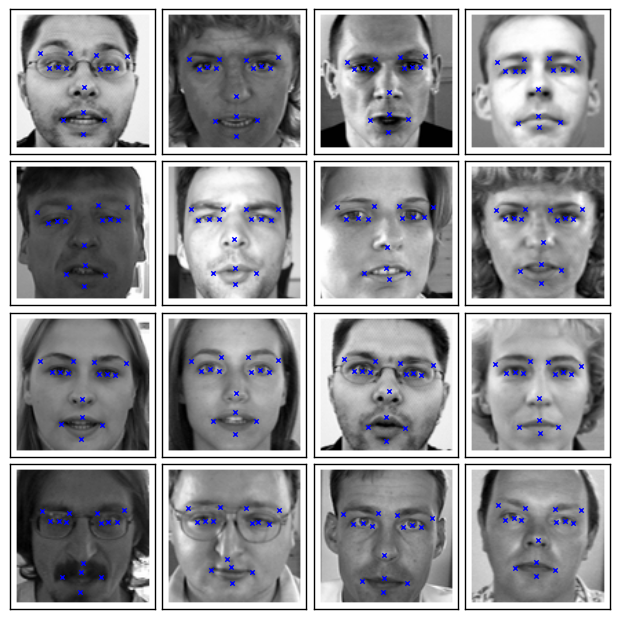

In [80]:
# モデル8の予測を表示
plot_samples(X_test2d, y_test)

In [81]:
# CSVで書き出す
output_df = pd.DataFrame(outputs, columns=['RowId', 'Location'])
output_df.to_csv(outpath, index=False)